<a href="https://colab.research.google.com/github/DaraSamii/lattice-boltzmann-method-python/blob/main/Lattice_Boltzmann_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from IPython import display

#Simulation Parameters

In [38]:
Nx = 400
Ny = 100

rho0 = 100
tau = 0.6
Nt = 10000

# Lattice speeds / Weights

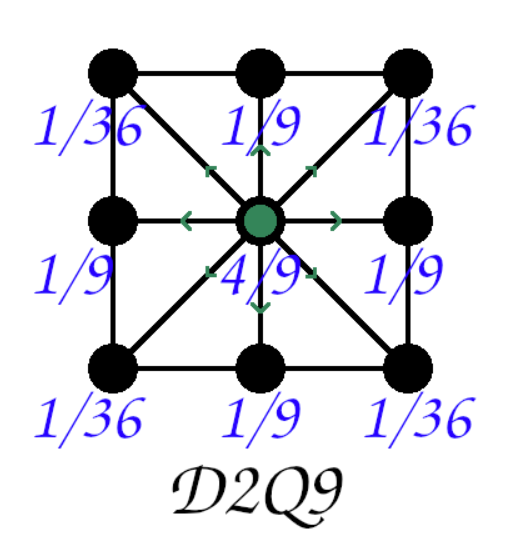

In [39]:
NL = 9
idxs = np.arange(NL)
print(idxs)

cxs = np.array([0,0,1,1,1,0,-1,-1,-1])
cys = np.array([0,1,1,0,-1,-1,-1,0,1])

weights = np.array([4/9, 1/9, 1/36, 1/9, 1/36, 1/9,1/36,1/9,1/36])
print(weights.sum())

[0 1 2 3 4 5 6 7 8]
1.0


In [40]:
X,Y = np.meshgrid(range(Nx), range(Ny))
print(X.shape)
print(Y.shape)

(100, 400)
(100, 400)


#Initial Conditions

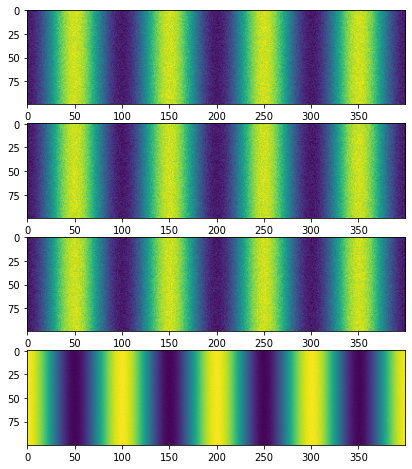

In [48]:
F = np.ones((Ny, Nx, NL)) + 0.01 *np.random.rand(Ny,Nx,NL)
F[:,:,3] += 2 * (1+0.2*np.cos(2*np.pi*X/Nx*4))

rho = np.sum(F,2)

for i in idxs:
    F[:,:,i] *= rho0/rho

plt.figure(figsize=(8,8))

plt.subplot(4,1,1)
plt.imshow(F[:,:,0])
plt.subplot(4,1,2)
plt.imshow(F[:,:,1])
plt.subplot(4,1,3)
plt.imshow(F[:,:,2])
plt.subplot(4,1,4)
plt.imshow(F[:,:,3])

# Cylinder boundary

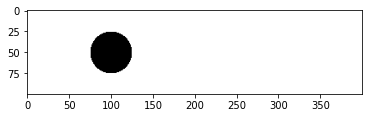

In [49]:
cylinder = ((X - Nx/4)**2) + (Y-Ny/2)**2 < (Ny/4)**2
plt.imshow(cylinder,cmap='gray_r')

#Simulation Main loop

$\rho = ∑ F_i$

$\rho u = \sum F_i v_i$

In [50]:
def compute_fluid_vars(F,cxs,cys):
    '''
    this function computes density and velocity in x direction(ux) and velocity in y directio(uy)
    '''
    rho = np.sum(F,2)
    ux = np.sum(F*cxs,2) / rho
    uy = np.sum(F*cys,2)/ rho

    return rho, ux, uy


$F_i^{eq} = w_i \rho (1 = 3(v_i.u) + \frac{9}{2}(v_i,u)^2 + \frac{3}{2}(u.u)^2)$

In [51]:
def compute_Feq(cx,cy,w,ux,uy,rho):
    '''
    this function computes the Equilibrium state
    '''
    term1 = 1 + 3*(cx*ux + cy*uy)
    term2 = (9*(cx*ux + cy*uy)**2)/2
    term3 = -3*(ux**2 + uy**2)/2

    return rho * w * (term1 + term2 + term3)

$F_i(x_i + v_i\Delta t, t + \Delta t) = F_i(x_i,t) - \frac{F_i(x_i,t) - F_i^{eq}(x_i,t)}{\tau}$

In [52]:
#empy matrix for storing Vorticity results
Vor = np.zeros((Ny,Nx,Nt))

#main loop
for it in tqdm(range(Nt)):

    for i, cx, cy in zip(idxs, cxs,cys):
        F[:,:,i] = np.roll(F[:,:,i], cx, axis=1)
        F[:,:,i] = np.roll(F[:,:,i], cy, axis=0)

    # geometry boundaries
    bndryF = F[cylinder,:]
    bndryF = bndryF[:,[0,5,6,7,8,1,2,3,4]]

    #retriving fluid vairables
    rho, ux, uy = compute_fluid_vars(F, cxs, cys)

    #Computing F_eq
    Feq = np.zeros(F.shape)
    for i,cx,cy,w in zip(idxs, cxs, cys, weights):
        Feq[:,:,i] = compute_Feq(cx,cy,w,ux,uy,rho)

    #updating F
    F += -(1.0/tau) * (F - Feq)

    #Applying boundaries
    F[cylinder,:] = bndryF

    #Compute Vorticity
    ux[cylinder] = 0.0
    uy[cylinder] = 0.0
    vorticity = (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - (np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1))
    vorticity[cylinder] = np.nan

    #storing Vorticity
    Vor[:,:,it] = vorticity

100%|██████████| 10000/10000 [04:48<00:00, 34.69it/s]


# Creating Animation

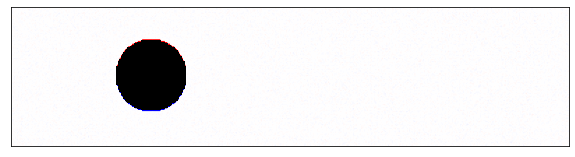

In [53]:
#setting Plot options
fig = plt.figure(figsize=(10,10))

#colormap options
cmap = plt.cm.bwr
cmap.set_bad('black')

#first frame
im = plt.imshow(Vor[:,:,0], cmap='bwr')
plt.clim(-.1, .1)

#ax setup
ax = plt.gca()
ax.invert_yaxis()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)	
ax.set_aspect('equal')	

def FUNC(frame):
    im.set_array(Vor[:,:,frame])

anim_created = FuncAnimation(fig, FUNC, frames=Nt, interval=5)

In [54]:
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

plt.close()